# Label SAR Data

### This notebook will utilize Wildland Fire Interagency Geospatial Services (WFIGS) perimeter data to determine the extent of the wildfires present in the SAR images.

To replicate this notebook, you need to download GeoJSON file from https://data-nifc.opendata.arcgis.com/datasets/7c81ab78d8464e5c9771e49b64e834e9_0/explore?showTable=true

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from shapely.geometry import box
from matplotlib_scalebar.scalebar import ScaleBar

### Load in Wildfire Perimeter Data

In [2]:
# Gather data into GeoDataFrame
data_path = '~/FIREMAPS/Data/'
data_file = 'WFIGS_Interagency_Perimeters_YearToDate_7244446855919551728.geojson'
file_path = data_path + data_file

wfigs_data = gpd.read_file(file_path)
wfigs_data['poly_IncidentName'] = wfigs_data['poly_IncidentName'].astype(str).str.lower()

# list from https://en.wikipedia.org/wiki/January_2025_Southern_California_wildfires
fires_wanted = ['palisades', 'eaton', 'bert', 'hurst', 'lidia', 'sunset', 'sunswept', 'kenneth', 'hughes']

wfigs_la = wfigs_data[wfigs_data['poly_IncidentName'].isin(fires_wanted)]
wfigs_la

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_DeleteThis,poly_FeatureAccess,poly_FeatureStatus,poly_IsVisible,...,attr_CreatedOnDateTime_dt,attr_ModifiedOnDateTime_dt,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,attr_IncidentComplexityLevel,geometry
17,36398,172,palisades,Wildfire Daily Fire Perimeter,IR Image Interpretation,23448.000000,No,Public,Approved,Yes,...,"Tue, 07 Jan 2025 19:23:56 GMT","Sat, 01 Feb 2025 01:45:24 GMT",IRWIN,0.0,None,None,{35C19D7C-FEDA-42F8-AD76-9B094E783801},2a11c9e3-3295-4623-8c53-4e9a192ae0f3,Type 3 Incident,"MULTIPOLYGON (((-118.56093 34.04408, -118.5609..."
20,36410,615,eaton,Wildfire Daily Fire Perimeter,Mixed Methods,14021.108712,No,Public,Approved,Yes,...,"Wed, 08 Jan 2025 02:22:48 GMT","Wed, 05 Mar 2025 17:44:11 GMT",IRWIN,0.0,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},52bfca63-1058-40fe-a4b8-ec17b36361c1,Type 4 Incident,"MULTIPOLYGON (((-118.08301 34.23769, -118.0830..."
22,36411,312,hurst,Wildfire Daily Fire Perimeter,Mixed Methods,799.817638,No,Public,Approved,Yes,...,"Wed, 08 Jan 2025 06:53:19 GMT","Fri, 17 Jan 2025 01:20:08 GMT",IRWIN,0.0,None,None,{D69D1FE4-0B5E-43AF-89FF-BD4757EF0DFA},a54b079e-9b60-497f-bbb6-672f21184aa0,Type 3 Incident,"POLYGON ((-118.47458 34.34255, -118.47434 34.3..."
28,36421,266,kenneth,Wildfire Daily Fire Perimeter,IR Image Interpretation,998.737772,No,Public,Approved,Yes,...,"Thu, 09 Jan 2025 22:55:01 GMT","Sun, 12 Jan 2025 13:47:07 GMT",IRWIN,0.0,None,None,{99DAB162-D90A-44E4-9326-756A20C336B4},441e30cb-a3f3-4b71-8518-7025a19d821f,Type 3 Incident,"POLYGON ((-118.67692 34.16894, -118.6769 34.16..."
60,36658,912,hughes,Wildfire Daily Fire Perimeter,IR Image Interpretation,10425.343367,No,Public,Approved,Yes,...,"Wed, 22 Jan 2025 18:43:27 GMT","Wed, 05 Mar 2025 17:43:43 GMT",IRWIN,0.0,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},34bbdfd9-eec4-4c10-8e82-294091e86685,Type 3 Incident,"MULTIPOLYGON (((-118.58018 34.53925, -118.5811..."


Text(0.5, 1.0, 'LA Wildfires, January 2025')

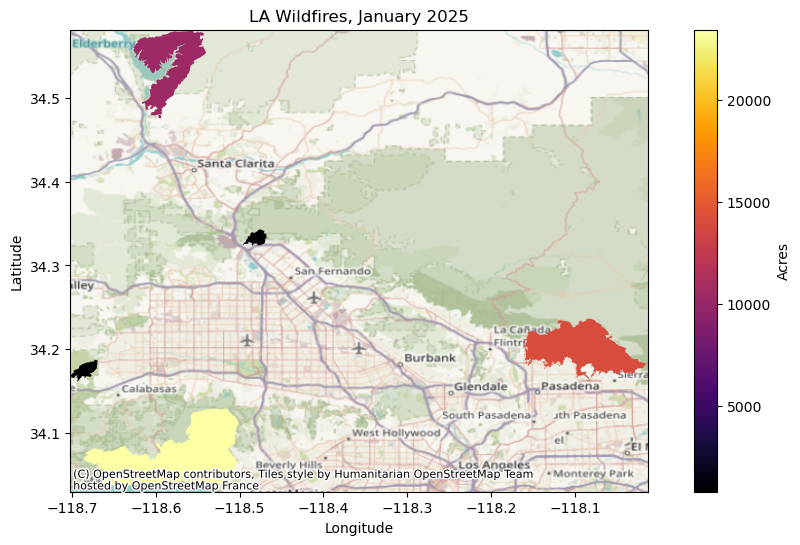

In [5]:
# Plot LA wildfires Jan 2025
f, ax = plt.subplots(figsize=(12,6))

wfigs_la.plot(ax = ax, column = 'poly_GISAcres', cmap = 'inferno', legend = True,
                     legend_kwds = {'label': 'Acres'}, markersize = 2)
ctx.add_basemap(ax, crs=wfigs_la.crs) #, source = ctx.providers.OpenTopoMap)
ax.set_xlim(wfigs_la.total_bounds[0], wfigs_la.total_bounds[2])
ax.set_ylim(wfigs_la.total_bounds[1], wfigs_la.total_bounds[3])

ax.set_aspect('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('LA Wildfires, January 2025')

#plt.savefig("LA_wildfires.png", dpi=500)

### Load in SAR Images

In [6]:
local_directory = os.path.expanduser('~/FIREMAPS/Data/Wildfires/')
tif_files = [f for f in os.listdir(local_directory) if f.endswith('.tif')]

if tif_files:
    print("Downloaded tif files:")
    for file in tif_files:
        print(file)
else:
    print("No tif files found in the directory.")

Downloaded tif files:
CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823.tif
CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111.tif
CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.tif
CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441.tif
CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506.tif
CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104.tif
CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753.tif


In [9]:
# Choose SAR image to work with
tif_name = "CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.tif"  
tif_file = os.path.join(local_directory, tif_name) 
tif_basename = os.path.splitext(os.path.basename(tif_file))[0]

with rasterio.open(tif_file) as src:
    # downsample SAR
    down_factor = 6  
    new_height = src.height // down_factor
    new_width = src.width // down_factor

    # read SAR data
    img_data = src.read(
        1,  
        out_shape=(new_height, new_width), 
        resampling=Resampling.average 
    )
    
    # get SAR CRS
    crs = src.crs
    wfigs_la = wfigs_la.to_crs(crs)

    # get SAR bounds
    sar_bounds = src.bounds
    sar_bbox = box(sar_bounds.left, sar_bounds.bottom, sar_bounds.right, sar_bounds.top)



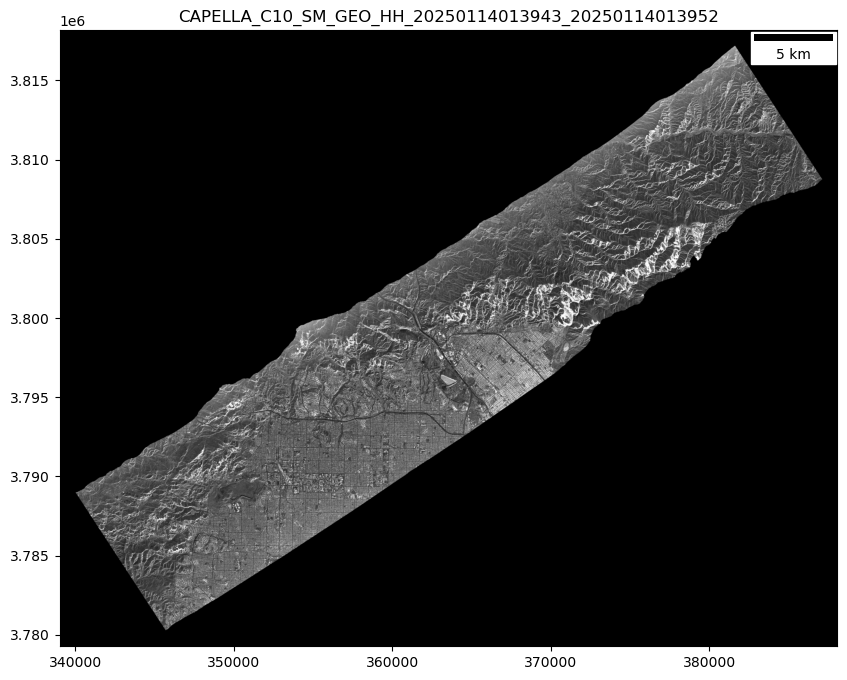

In [12]:
# Plot SAR image
f, ax = plt.subplots(figsize=(12, 8))

ax.imshow(img_data, cmap='gray', extent=(sar_bounds.left, sar_bounds.right, sar_bounds.bottom, sar_bounds.top),
          vmin=0, vmax=1500)

ax.set_title(f'{tif_basename}')
ax.set_xlim(sar_bounds.left, sar_bounds.right)
ax.set_ylim(sar_bounds.bottom, sar_bounds.top)

ax.set_aspect('equal')
ax.add_artist(ScaleBar(1))
#plt.savefig("CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952.png", dpi=500)

### Find overlapping geometry

Number of overlapping fire perimeters: 3
Overlapping fire(s): ['hurst' 'kenneth' 'hughes']


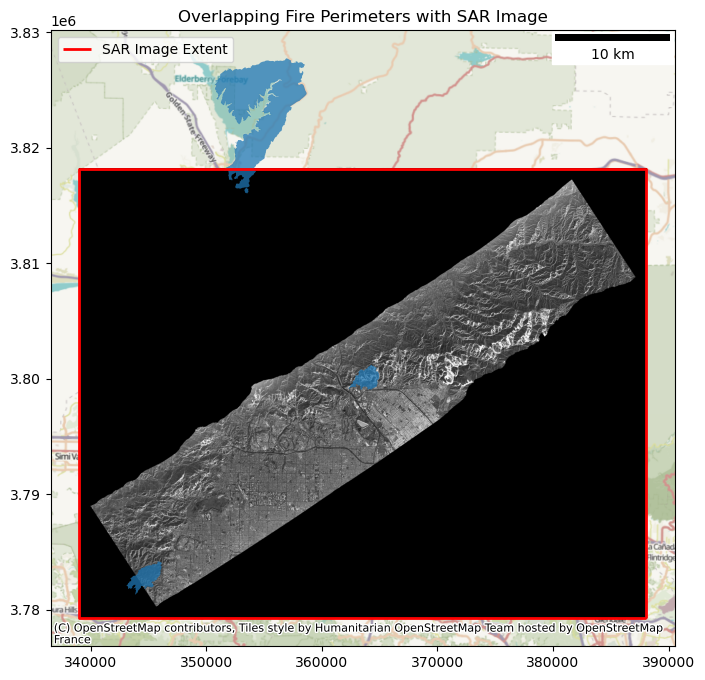

In [15]:
# Create gdf from SAR geometry
sar_gdf = gpd.GeoDataFrame({'geometry': [sar_bbox]}, crs=wfigs_la.crs)

overlapping_fires = wfigs_la[wfigs_la.intersects(sar_bbox)]

print(f"Number of overlapping fire perimeters: {len(overlapping_fires)}")
print(f"Overlapping fire(s): {overlapping_fires['poly_IncidentName'].values}")  

f, ax = plt.subplots(figsize=(12, 8))

sar_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label="SAR Image Extent")
overlapping_fires.plot(ax=ax, alpha=0.75)
ctx.add_basemap(ax, crs=wfigs_la.crs)
ax.imshow(img_data, cmap='gray', extent=(sar_bounds.left, sar_bounds.right, sar_bounds.bottom, sar_bounds.top),
          vmin=0, vmax=1500)

ax.set_title('Overlapping Fire Perimeters with SAR Image')
ax.legend(loc = 'upper left')
ax.add_artist(ScaleBar(1))
#plt.savefig("Overlapping_Fire_SAR.png", dpi=500)

Overlapping regions saved to /home/jovyan/FIREMAPS/Data/GeoJSON/CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952_fire_overlap.geojson


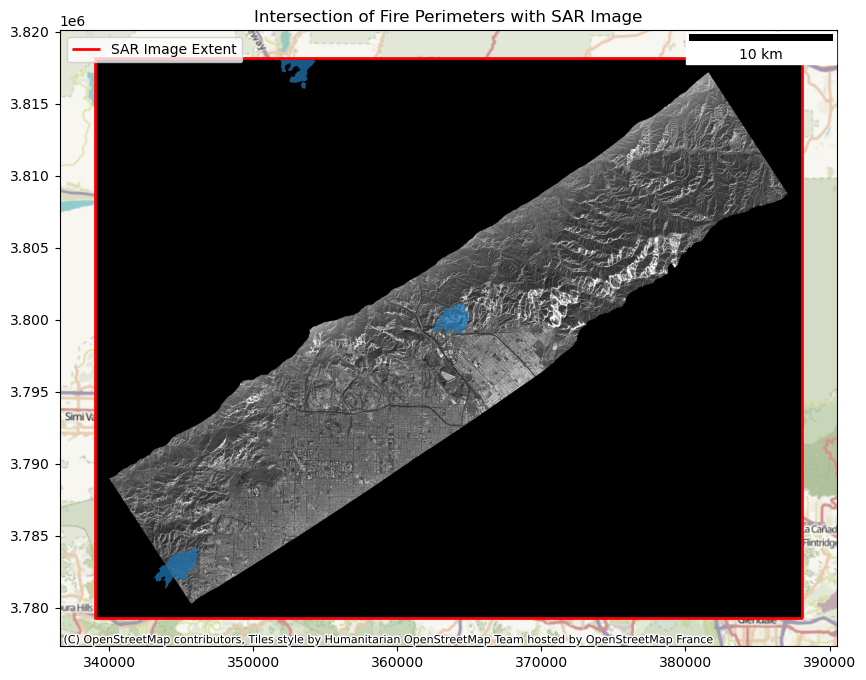

In [17]:
overlapping_polygons = []

output_json_dir = os.path.expanduser('~/FIREMAPS/Data/GeoJSON/')

# add intersections between fires and SAR extent
for _, row in wfigs_la.iterrows():
    fire_polygon = row.geometry  
    intersection = sar_bbox.intersection(fire_polygon)

    if not intersection.is_empty:
        overlapping_polygons.append(intersection)

if overlapping_polygons:
    overlapping_gdf = gpd.GeoDataFrame(geometry=overlapping_polygons, crs=wfigs_la.crs)
    
    output_geojson = os.path.join(output_json_dir, f"{tif_basename}_fire_overlap.geojson")
    os.makedirs(output_json_dir, exist_ok=True)
    overlapping_gdf.to_file(output_geojson, driver="GeoJSON")
    print(f"Overlapping regions saved to {output_geojson}")
                                  
else:
    print("No overlapping regions found.")

f, ax = plt.subplots(figsize=(12, 8))

sar_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label="SAR Image Extent")

overlapping_gdf.plot(ax=ax,  alpha=0.75)

ctx.add_basemap(ax, crs=wfigs_la.crs)

ax.imshow(img_data, cmap='gray', extent=(sar_bounds.left, sar_bounds.right, sar_bounds.bottom, sar_bounds.top),
          vmin=0, vmax=1500)

ax.set_title('Intersection of Fire Perimeters with SAR Image')
ax.legend(loc = 'upper left')
ax.add_artist(ScaleBar(1))
#plt.savefig("Intersection_Fire_SAR.png", dpi=500)